<a href="https://colab.research.google.com/github/TomFrederik/lucent/blob/dev/notebooks/neuron_interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neuron Interactions

This notebook combines the [`neuron_interaction`](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb) and [`negative_neuron`](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/negative_neurons.ipynb) notebooks from Lucid.

## Install, Import, Load Model

In [1]:
!pip install --quiet git+https://github.com/TomFrederik/lucent.git

     |████████████████████████████████| 225 kB 5.2 MB/s 


In [2]:
import torch
from torchvision.models import googlenet

from lucent.optvis import render, param, transform, objectives
from lucent.misc.io.showing import animate_sequence

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = googlenet(pretrained=True)
_ = model.to(device).eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## Negative Channel Visualizations

Just like in Lucid, we can generate visualizations that maximize activations in both the positive and negative directions.

Note that the positive term has the ``batch=1`` keyword while the negative term has the ``batch=0`` keyword. So the left image optimizes the negative term and the right image optimizes the positive term.

100%|██████████| 512/512 [00:29<00:00, 17.53it/s]



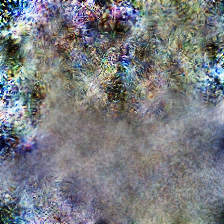
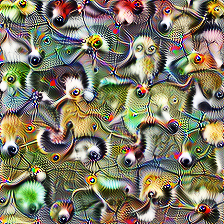

In [4]:
param_f = lambda: param.image(224, batch=2)
obj = objectives.channel("inception4a", 492, batch=1) - objectives.channel("inception4a", 492, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:28<00:00, 17.91it/s]



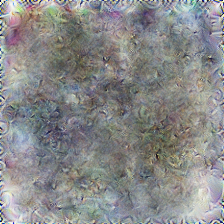
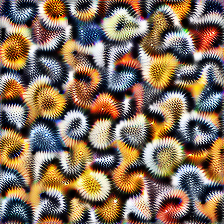

In [5]:
# Dark and light
obj = objectives.channel("inception4a", 104, batch=1) - objectives.channel("inception4a", 104, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:30<00:00, 16.95it/s]



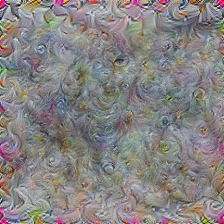
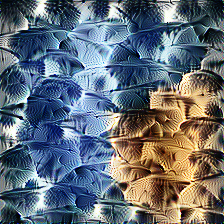

In [6]:
# Galaxy balls and wyrm husks
obj = objectives.channel("inception4b", 154, batch=1) - objectives.channel("inception4b", 154, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

## Combining Neurons

As shown in the [tutorial](https://colab.research.google.com/github/greentfrapp/lucent-notebooks/blob/master/notebooks/tutorial.ipynb), we can also combine objectives and the resulting visualizations form an intuitive amalgam of the inputs.

The corresponding Lucid [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb) already has a set of nice channels for combining.

In [7]:
#TODO: update comments that give hints as to which neuron is what

neuron1 = ('inception4b', 111)     # large fluffy
# neuron1 = ('inception3a', 139)   # pointilist
# neuron1 = ('inception3b',  81)   # brush trokes
# neuron1 = ('inception4a',  97)   # wavy
# neuron1 = ('inception4a',  41)   # frames
# neuron1 = ('inception4a', 479)   # B/W

neuron2 = ('inception4a', 476)     # art
# neuron2 = ('inception4b', 360)   # lattices
# neuron2 = ('inception4b', 482)   # arcs
# neuron2 = ('inception4c', 440)   # small fluffy
# neuron2 = ('inception4d', 479)   # bird beaks
# neuron2 = ('inception4e', 718)   # shoulders

100%|██████████| 512/512 [00:27<00:00, 18.87it/s]



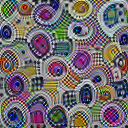
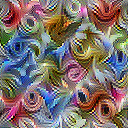
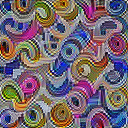

In [8]:
param_f = lambda: param.image(128, batch=3)

# First image optimizes neuron1
# Second image optimizes neuron2
# Third image optimizes sum of both
C = lambda neuron1, neuron2: objectives.channel(*neuron1, batch=0) + \
  objectives.channel(*neuron2, batch=1) + \
  objectives.channel(*neuron1, batch=2) + \
  objectives.channel(*neuron2, batch=2)

_ = render.render_vis(model, C(neuron1, neuron2), param_f, show_inline=True)

Uncomment the code and try it out for yourself!

## Aligned Interpolation

The authors of the Feature Visualization [article](https://distill.pub/2017/feature-visualization/) also invented a neat way to interpolate between objectives that encouraged spatial coherence.

In essence, we have a batch of images that all share a set of interpolated source tensors, which helps to encourage alignment. For more details, check out the Lucid [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/aligned_interpolation.ipynb) on this topic!

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 512/512 [00:19<00:00, 25.91it/s]



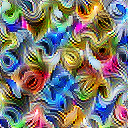
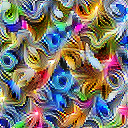
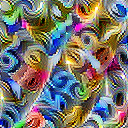
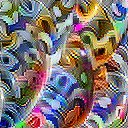
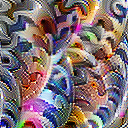
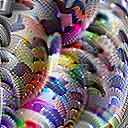

In [4]:
def interpolate_param_f():
  # We start with a batch of FFT parameterized images
  params, image_f = param.fft_image((6, 3, 128, 128))
  # We then add a bunch of low-res interpolated tensors
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  # Accumulate the params and outputs
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("inception4a", 476, "inception4d->branch2->0", 139)

sequence = render.render_vis(model, obj, interpolate_param_f, show_inline=True)


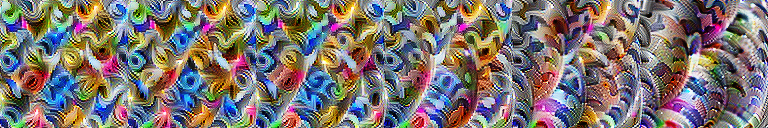

In [5]:
animate_sequence(sequence[0])

We see it interpolating and some parts of the images are aligned!

In addition to the new parameterization, Lucid also introduced an alignment objective to further encourage spatial coherence, by minimizing the difference between feature representations. Again, you can read more about this in a detailed Lucid [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/aligned_interpolation.ipynb)!

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 512/512 [00:20<00:00, 25.09it/s]



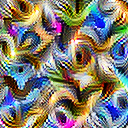
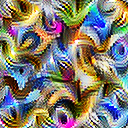
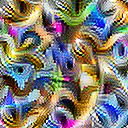
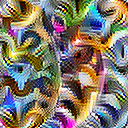
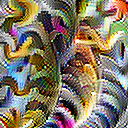
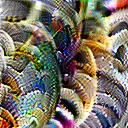


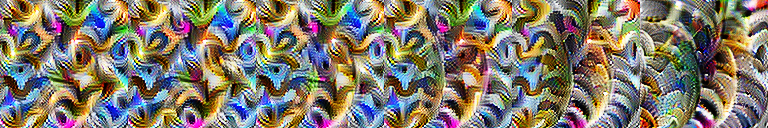

In [6]:
def full_interpolate_obj(layer1, channel1, layer2, channel2):
  interpolation_objective = objectives.channel_interpolate(layer1, channel1, layer2, channel2)
  alignment_objective = objectives.alignment('inception3b', decay_ratio=5) # encourage similarity in this layer
  return interpolation_objective + 1e-1 * alignment_objective

# Set up transforms for a nicer image
transforms = [
    transform.pad(12, mode="constant", constant_value=.5),
    transform.jitter(8),
    transform.random_scale([.75]),
]

obj = full_interpolate_obj("inception4a", 476, "inception4d->branch2->0", 139)
sequence = render.render_vis(model, obj, interpolate_param_f, transforms=transforms, show_inline=True)
animate_sequence(sequence[0])

More examples from the Feature Visualization [paper](https://distill.pub/2017/feature-visualization/#interaction).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 512/512 [00:18<00:00, 27.13it/s]



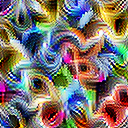
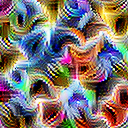
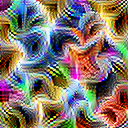
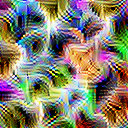
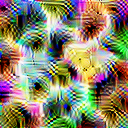
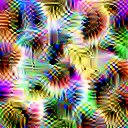


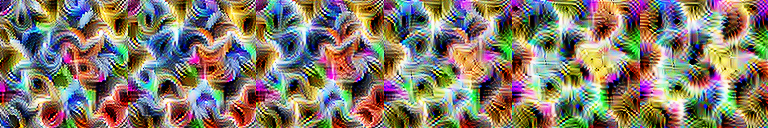

In [7]:
obj = full_interpolate_obj("inception4a", 476, "inception4a", 455)
sequence = render.render_vis(model, obj, interpolate_param_f, transforms=transforms, show_inline=True)
animate_sequence(sequence[0])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 512/512 [00:18<00:00, 27.13it/s]



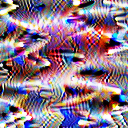
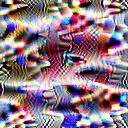
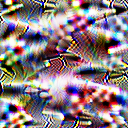
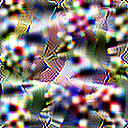
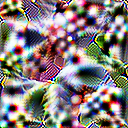
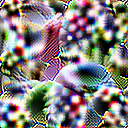


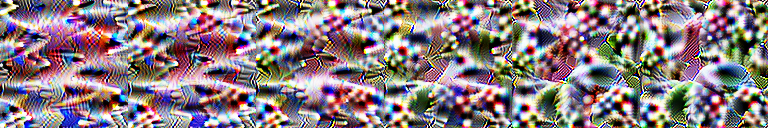

In [8]:
obj = full_interpolate_obj("inception4a", 460, "inception4a", 501)
sequence = render.render_vis(model, obj, interpolate_param_f, transforms=transforms, show_inline=True)
animate_sequence(sequence[0])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 512/512 [00:22<00:00, 22.69it/s]



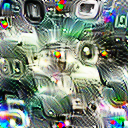
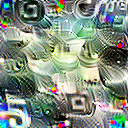
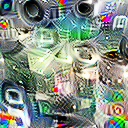
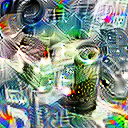
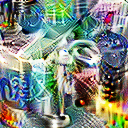
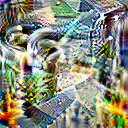


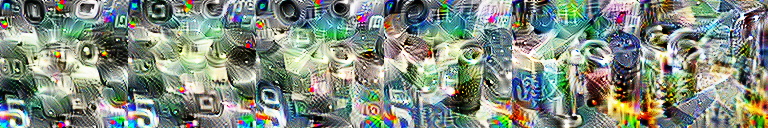

In [9]:
obj = full_interpolate_obj("inception4d", 503, "inception5a", 791)
sequence = render.render_vis(model, obj, interpolate_param_f, transforms=transforms, show_inline=True)
animate_sequence(sequence[0])